In [1]:
import pandas as pd
import numpy as np
import copy
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
#plt.style.use('dark_background')

from scipy.stats import rankdata
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import f1_score, make_scorer

In [2]:
# Loading intersection data

filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/'
data_inter = pd.read_csv(filepath + 'intersection.csv')
data_inter = data_inter.dropna()  # Remove rows with NaN values
data_inter = data_inter.replace([np.inf, -np.inf], np.nan).dropna()

ml_methods = ['score_sims', 'K_SCORE', 'SINGLE']

"""
for i in range(len(ml_methods)):
    ranks = rankdata(data_inter[ml_methods[i]], method='average').astype(float)
    ranks = (ranks - 1) / (ranks.max() - 1)
    data_inter[ml_methods[i] + '_rank_aver'] = ranks
"""

"\nfor i in range(len(ml_methods)):\n    ranks = rankdata(data_inter[ml_methods[i]], method='average').astype(float)\n    ranks = (ranks - 1) / (ranks.max() - 1)\n    data_inter[ml_methods[i] + '_rank_aver'] = ranks\n"

In [3]:
# Loading Exp. Data

data_zoo = pd.read_csv('data/complete_data.csv')

filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/data/in_sled2.fits'
hdu_list = fits.open(filepath)
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

data.replace('None', np.nan, inplace=True)
data = data.astype({'COADD_OBJECT_ID': int, 'K_RA': float, 'K_DEC': float, 'K_SCORE': float, 'Y3_COADD_OBJECT_ID': int,
       'J_RA': float, 'J_DEC': float, 'score_sims': float, 'score_real': float, 'score_both': float, 'G_RA': float,
       'G_DEC': float, 'SINGLE': float, 'RING': float, 'SMOOTH': float, 'COMPANIONS': float, 'SDSS_SPIRALS': float,
       'DES_SPIRALS': float, 'CROWDED': float, 'ARTIFACTS': float, 'MOST_NEGATIVES': float, 'index': int, 'ra': float,
       'dec': float, 'name': str, 'score': float, 'image_sep': float, 'info': str, 'n_img': float, 'flag': str,
       'image_conf': str, 'lens_type': str, 'source_type': str, 'contaminant_type': str, 'papers': str})

#Getting the images
data.set_index('COADD_OBJECT_ID', inplace=True)
data_zoo.set_index('COADD_OBJECT_ID', inplace=True)
# Reindex 'data' to match the index of 'data_zoo'
data = data.reindex(data_zoo.index)
# Reset index if needed
data.reset_index(inplace=True)
data_zoo.reset_index(inplace=True)
images = images[data.index]

print(len(data), len(data_zoo))

# For working with rankings instead of the ML output
"""
data_zoo = data_zoo.merge(data_inter[['COADD_OBJECT_ID', 'score_sims_rank_aver', 'K_SCORE_rank_aver', 
                    'SINGLE_rank_aver']], on='COADD_OBJECT_ID', how='inner')

#Renaming ranks to original ML names
data_zoo = data_zoo.drop(ml_methods, axis=1)
data_zoo = data_zoo.rename({'score_sims_rank_aver': 'score_sims', 'K_SCORE_rank_aver': 'K_SCORE', 
                            'SINGLE_rank_aver': 'SINGLE'}, axis=1)
"""

1651 1651


"\ndata_zoo = data_zoo.merge(data_inter[['COADD_OBJECT_ID', 'score_sims_rank_aver', 'K_SCORE_rank_aver', \n                    'SINGLE_rank_aver']], on='COADD_OBJECT_ID', how='inner')\n\n#Renaming ranks to original ML names\ndata_zoo = data_zoo.drop(ml_methods, axis=1)\ndata_zoo = data_zoo.rename({'score_sims_rank_aver': 'score_sims', 'K_SCORE_rank_aver': 'K_SCORE', \n                            'SINGLE_rank_aver': 'SINGLE'}, axis=1)\n"

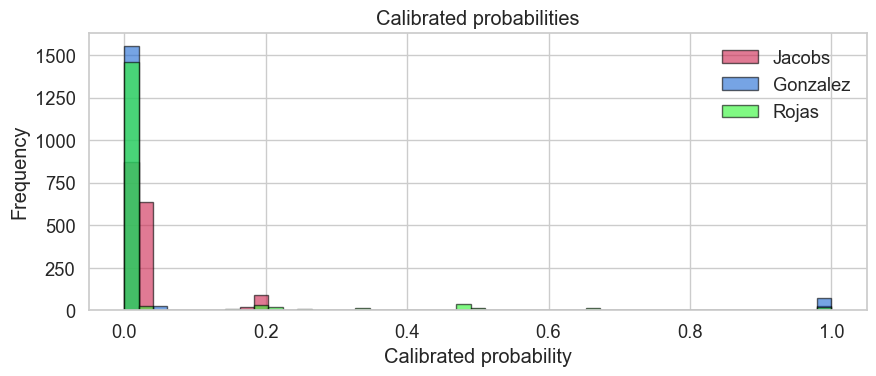

In [4]:
#Adding calibrated probabilities: N_lenses/total for a value of rank
prob_threshold = 1.75 #

for score in data_zoo['score_sims'].unique():
    data_tmp = data_zoo[data_zoo['score_sims'] == score]
    N_lens = len(data_tmp[data_tmp['average'] > prob_threshold])
    fraction = N_lens/len(data_tmp)
    #print(fraction)
    data_zoo.loc[data_zoo['score_sims'] == score, 'calib_jacobs'] = fraction
    
for score in data_zoo['K_SCORE'].unique():
    data_tmp = data_zoo[data_zoo['K_SCORE'] == score]
    N_lens = len(data_tmp[data_tmp['average'] > prob_threshold])
    fraction = N_lens/len(data_tmp)
    data_zoo.loc[data_zoo['K_SCORE'] == score, 'calib_rojas'] = fraction
    
for score in data_zoo['SINGLE'].unique():
    data_tmp = data_zoo[data_zoo['SINGLE'] == score]
    N_lens = len(data_tmp[data_tmp['average'] > prob_threshold])
    fraction = N_lens/len(data_tmp)
    data_zoo.loc[data_zoo['SINGLE'] == score, 'calib_gonzalez'] = fraction
    #print(fraction)

# Distribution of calibrated probabilities
sns.set(style='whitegrid', font_scale=1.2)
all_scores = np.concatenate([data_zoo['calib_jacobs'], 
                             data_zoo['calib_rojas'], data_zoo['calib_gonzalez']])
bins = np.linspace(0, 1, 50)  # 30 equally spaced bins in [0, 1] (assuming values are normalized ranks)
plt.figure(figsize=(9, 4))
plt.hist(data_zoo['calib_jacobs'], bins=bins, alpha=0.6, label='Jacobs', color='#cc224d', edgecolor='black')
plt.hist(data_zoo['calib_rojas'],      bins=bins, alpha=0.6, label='Gonzalez', color='#1b67d2', edgecolor='black')
plt.hist(data_zoo['calib_gonzalez'],     bins=bins, alpha=0.6, label='Rojas',  color='#2cf531', edgecolor='black')
plt.xlabel('Calibrated probability')
plt.ylabel('Frequency')
plt.title('Calibrated probabilities')
#plt.yscale('log')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [5]:
#Separating a test sample to evaluate all methods on
score_threshold = 1.75

data_zoo['ML_average'] = data_zoo[['score_sims', 'K_SCORE', 'SINGLE']].mean(axis=1)
data_zoo['ML_median'] = data_zoo[['score_sims', 'K_SCORE', 'SINGLE']].median(axis=1)

X = data_zoo[['score_sims', 'K_SCORE', 'SINGLE', 'COADD_OBJECT_ID']]
y = data_zoo[['average', 'calib_jacobs', 'calib_rojas', 'calib_gonzalez']] #Expert score = True labels

score_threshold = 1.75
data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
coadd_train, coadd_test = data_train[['COADD_OBJECT_ID']], data_test[['COADD_OBJECT_ID']]
data_train, data_test = data_train.drop(['COADD_OBJECT_ID'], axis = 1), data_test.drop(['COADD_OBJECT_ID'], axis = 1)
y_train_class = (y_train['average'] > score_threshold).astype(int) #0 = negative, 1 = positive

# Training linear regression model
model = LinearRegression()
model.fit(data_train, y_train['average'])

# Isotonic regression - regression Jacobs
jacobs_iso = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds='clip')
transformed = jacobs_iso.fit_transform(data_train['score_sims'], y_train['calib_jacobs'])

# Isotonic regression - regression Rojas
rojas_iso = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds='clip')
transformed = rojas_iso.fit_transform(data_train['K_SCORE'], y_train['calib_rojas'])

# Isotonic regression - regression Gonzalez
gonzalez_iso = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds='clip')
transformed = gonzalez_iso.fit_transform(data_train['SINGLE'], y_train['calib_gonzalez'])

In [6]:
print(len(data_zoo[data_zoo['average'] > score_threshold]))

74


In [7]:
#Fine-tuning hyperparameters

#Finding best hyperparameters for decision tree regressor
param_grid = {'min_samples_leaf': [1, 5, 10, 20, 50], 'max_depth': [None, 3, 5, 10, 15]}
dt_reg = DecisionTreeRegressor(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(dt_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
grid.fit(data_train, y_train['average'].values.ravel())
print("Best parameters:", grid.best_params_)
print("Best Negative MSE (CV):", grid.best_score_)
dt_model = DecisionTreeRegressor(**grid.best_params_, random_state=42)
dt_model.fit(data_train, y_train['average'].values.ravel())

#Finding best hyperparameters for random forest regressor
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']}
rf_reg = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(rf_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
grid.fit(data_train, y_train['average'].values.ravel())
print("Best parameters:", grid.best_params_)
print("Best Negative MSE (CV):", grid.best_score_)
rf_model = RandomForestRegressor(**grid.best_params_, random_state=42)
rf_model.fit(data_train, y_train['average'].values.ravel())

#Finding best hyperparameters for decision tree classifier
param_grid = {'min_samples_leaf': [1, 5, 10, 20, 50], 'max_depth': [None, 3, 5, 10, 15]}
clf = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(data_train, y_train_class.values.ravel())
print("Best parameters:", grid.best_params_)
print("Best F1 score (CV):", grid.best_score_)
# Training decision tree - classification
dt_model_class = DecisionTreeClassifier(**grid.best_params_, random_state=42) #max_depth
dt_model_class.fit(data_train, y_train_class.values.ravel())

#Finding best hyperparameters for random forest classifier
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'], 'class_weight': [None, 'balanced']}
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(rf, param_grid=param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(data_train, y_train_class.values.ravel())
print("Best parameters:", grid.best_params_)
print("Best F1 score (CV):", grid.best_score_)
# Training Random Forest - classification
rf_model_class = RandomForestClassifier(**grid.best_params_, random_state=42)
rf_model_class.fit(data_train, y_train_class.values.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1}
Best Negative MSE (CV): -0.18001380175206544
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}
Best Negative MSE (CV): -0.18700805100737994
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 20}
Best F1 score (CV): 0.38198830409356727
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Best F1 score (CV): 0.4134252873563219


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=5,
                       n_estimators=200, random_state=42)

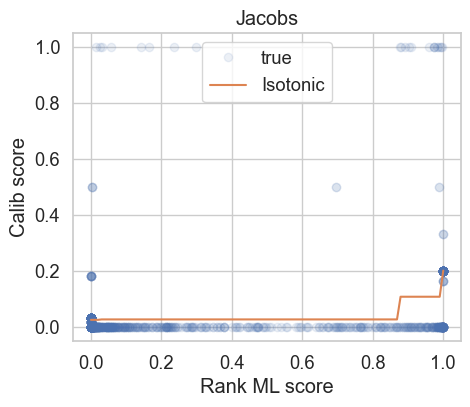

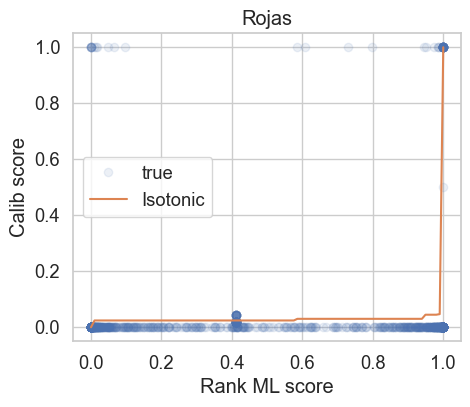

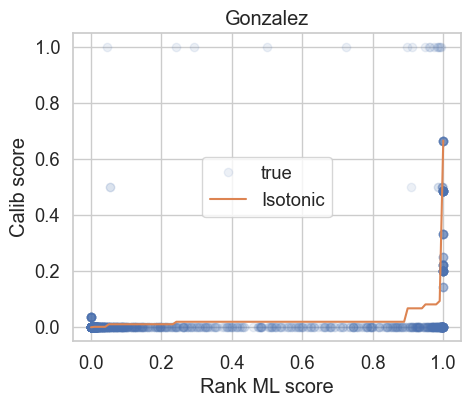

In [8]:
# Visualizing the isotonic regressions

x = np.linspace(0, 1, 100)

transformed = jacobs_iso.predict(x)
plt.figure(figsize=(5,4))
plt.plot(data_train['score_sims'], y_train['calib_jacobs'], 'o', alpha=0.1, label='true')
plt.plot(x, transformed, label='Isotonic')
plt.title('Jacobs')
plt.xlabel('Rank ML score')
plt.ylabel('Calib score')
plt.legend()
plt.show()
plt.close()

transformed = rojas_iso.predict(x)
plt.figure(figsize=(5,4))
plt.plot(data_train['K_SCORE'], y_train['calib_rojas'], 'o', alpha=0.1, label='true')
plt.plot(x, transformed, label='Isotonic')
plt.title('Rojas')
plt.xlabel('Rank ML score')
plt.ylabel('Calib score')
plt.legend()
plt.show()
plt.close()

transformed = gonzalez_iso.predict(x)
plt.figure(figsize=(5,4))
plt.plot(data_train['SINGLE'], y_train['calib_gonzalez'], 'o', alpha=0.1, label='true')
plt.plot(x, transformed, label='Isotonic')
plt.title('Gonzalez')
plt.xlabel('Rank ML score')
plt.ylabel('Calib score')
plt.legend()
plt.show()
plt.close()

[0.         0.00155001 0.01069519 0.01960784 0.06756757 0.08163265
 0.09375    0.66666667]
100 100


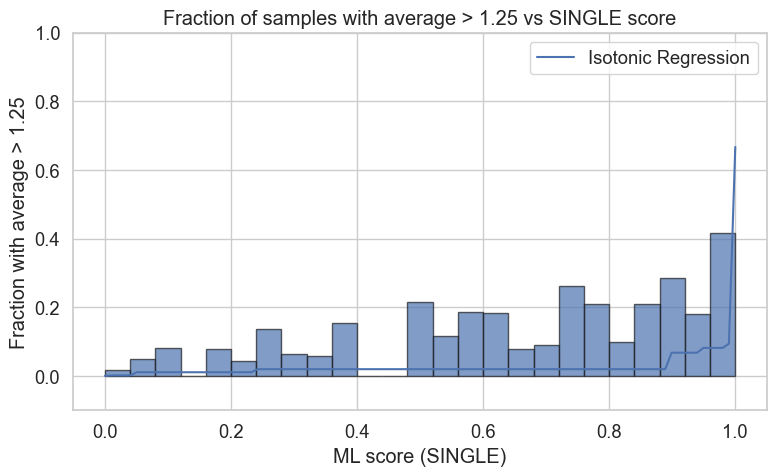

In [9]:
#gonzalez_iso = IsotonicRegression(out_of_bounds='clip')
#transformed = gonzalez_iso.fit_transform(data_train['SINGLE'], y_train['average'])

X = np.linspace(0, 1, 100)
Y = gonzalez_iso.predict(X)
print(np.unique(Y))
print(len(X), len(Y))

# Parameters
E = 0.02  # Half-bin width
bin_centers = np.arange(0 + E, 1 - E + 0.01, 2 * E)  # Centered bins

heights = []
for x in bin_centers:
    data_tmp = data_zoo[(data_zoo['SINGLE'] > x - E) & (data_zoo['SINGLE'] < x + E)]
    #print(data_tmp.columns)
    if len(data_tmp) == 0:
        heights.append(np.nan)  # Avoid division by zero
    else:
        N_L = len(data_tmp[data_tmp['average'] > 1.25])
        heights.append(N_L / len(data_tmp))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, heights, width=2*E, align='center', alpha=0.7, edgecolor='k')
plt.plot(X, Y, label='Isotonic Regression')
plt.xlabel('ML score (SINGLE)')
plt.ylabel('Fraction with average > 1.25')
plt.title('Fraction of samples with average > 1.25 vs SINGLE score')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.ylim(-0.1, 1)
#plt.xscale('log')
#plt.yscale('log')
plt.show()


In [10]:
#Testing all methods

N_BOOTSTRAPS = 100
score_threshold = 1.75

dict_metrics = {'thresholds': [], 'precision': [], 'recall': [], 'f1_scores': [], 'max_f1': [], 'roc_auc': []}
data_perf = {'Average': copy.deepcopy(dict_metrics), 'Median': copy.deepcopy(dict_metrics), 
             'Linear_regression': copy.deepcopy(dict_metrics), 'Decision_tree_reg': copy.deepcopy(dict_metrics),
             'Decision_tree_class': copy.deepcopy(dict_metrics), 'Random_forest_reg': copy.deepcopy(dict_metrics),
             'Random_forest_class': copy.deepcopy(dict_metrics),
             'Jacobs': copy.deepcopy(dict_metrics), 'Jacobs_iso': copy.deepcopy(dict_metrics),
             'Rojas': copy.deepcopy(dict_metrics), 'Rojas_iso': copy.deepcopy(dict_metrics),
            'Gonzalez': copy.deepcopy(dict_metrics),'Gonzalez_iso': copy.deepcopy(dict_metrics),
            'Ensemble_isotonic': copy.deepcopy(dict_metrics)}

for i in range(N_BOOTSTRAPS):
    data_test_bs, y_test_bs = resample(data_test, y_test, replace=True, random_state=i)
    y_true = y_test_bs['average'] > score_threshold
    if(y_true.sum() < 2): continue
    #Average
    y_pred_bs = data_test_bs[['score_sims', 'K_SCORE', 'SINGLE']].mean(axis=1)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Average']['max_f1'].append(max(f1_scores))
    data_perf['Average']['thresholds'].append(thresholds)
    data_perf['Average']['f1_scores'].append(f1_scores)
    data_perf['Average']['roc_auc'].append(roc_auc)
    data_perf['Average']['precision'].append(precision)
    data_perf['Average']['recall'].append(recall)
    #Median
    y_pred_bs = data_test_bs[['score_sims', 'K_SCORE', 'SINGLE']].median(axis=1)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Median']['max_f1'].append(max(f1_scores))
    data_perf['Median']['thresholds'].append(thresholds)
    data_perf['Median']['f1_scores'].append(f1_scores)
    data_perf['Median']['roc_auc'].append(roc_auc)
    data_perf['Median']['precision'].append(precision)
    data_perf['Median']['recall'].append(recall)
    #Linear regression
    y_pred_bs = model.predict(data_test_bs.values)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Linear_regression']['max_f1'].append(max(f1_scores))
    data_perf['Linear_regression']['thresholds'].append(thresholds)
    data_perf['Linear_regression']['f1_scores'].append(f1_scores)
    data_perf['Linear_regression']['roc_auc'].append(roc_auc)
    data_perf['Linear_regression']['precision'].append(precision)
    data_perf['Linear_regression']['recall'].append(recall)
    #Decision tree regression
    y_pred_bs = dt_model.predict(data_test_bs.values)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Decision_tree_reg']['max_f1'].append(max(f1_scores))
    data_perf['Decision_tree_reg']['thresholds'].append(thresholds)
    data_perf['Decision_tree_reg']['f1_scores'].append(f1_scores)
    data_perf['Decision_tree_reg']['roc_auc'].append(roc_auc)
    data_perf['Decision_tree_reg']['precision'].append(precision)
    data_perf['Decision_tree_reg']['recall'].append(recall)
    #Decision tree classification
    y_pred_bs = dt_model_class.predict_proba(data_test_bs)[:,1]  # assuming binary classification
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Decision_tree_class']['max_f1'].append(max(f1_scores))
    data_perf['Decision_tree_class']['thresholds'].append(thresholds)
    data_perf['Decision_tree_class']['f1_scores'].append(f1_scores)
    data_perf['Decision_tree_class']['roc_auc'].append(roc_auc)
    data_perf['Decision_tree_class']['precision'].append(precision)
    data_perf['Decision_tree_class']['recall'].append(recall)
    #Random forest
    y_pred_bs = rf_model.predict(data_test_bs.values)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Random_forest_reg']['max_f1'].append(max(f1_scores))
    data_perf['Random_forest_reg']['thresholds'].append(thresholds)
    data_perf['Random_forest_reg']['f1_scores'].append(f1_scores)
    data_perf['Random_forest_reg']['roc_auc'].append(roc_auc)
    data_perf['Random_forest_reg']['precision'].append(precision)
    data_perf['Random_forest_reg']['recall'].append(recall)
    #Random classification
    y_pred_bs = rf_model_class.predict_proba(data_test_bs)[:,1]  # assuming binary classification
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Random_forest_class']['max_f1'].append(max(f1_scores))
    data_perf['Random_forest_class']['thresholds'].append(thresholds)
    data_perf['Random_forest_class']['f1_scores'].append(f1_scores)
    data_perf['Random_forest_class']['precision'].append(precision)
    data_perf['Random_forest_class']['recall'].append(recall)
    data_perf['Random_forest_class']['roc_auc'].append(roc_auc)
    data_perf['Random_forest_class']['precision'].append(precision)
    data_perf['Random_forest_class']['recall'].append(recall)
    #Jacobs
    y_pred_bs = data_test_bs['score_sims']
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Jacobs']['max_f1'].append(max(f1_scores))
    data_perf['Jacobs']['thresholds'].append(thresholds)
    data_perf['Jacobs']['f1_scores'].append(f1_scores)
    data_perf['Jacobs']['precision'].append(precision)
    data_perf['Jacobs']['recall'].append(recall)
    data_perf['Jacobs']['roc_auc'].append(roc_auc)
    data_perf['Jacobs']['precision'].append(precision)
    data_perf['Jacobs']['recall'].append(recall)
    #Jacobs isotonic regression
    y_pred_bs = jacobs_iso.predict(data_test_bs['score_sims'])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Jacobs_iso']['max_f1'].append(max(f1_scores))
    data_perf['Jacobs_iso']['thresholds'].append(thresholds)
    data_perf['Jacobs_iso']['f1_scores'].append(f1_scores)
    data_perf['Jacobs_iso']['roc_auc'].append(roc_auc)
    data_perf['Jacobs_iso']['precision'].append(precision)
    data_perf['Jacobs_iso']['recall'].append(recall)
    #Rojas
    y_pred_bs = data_test_bs['K_SCORE']
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Rojas']['max_f1'].append(max(f1_scores))
    data_perf['Rojas']['thresholds'].append(thresholds)
    data_perf['Rojas']['f1_scores'].append(f1_scores)
    data_perf['Rojas']['precision'].append(precision)
    data_perf['Rojas']['recall'].append(recall)
    data_perf['Rojas']['roc_auc'].append(roc_auc)
    data_perf['Rojas']['precision'].append(precision)
    data_perf['Rojas']['recall'].append(recall)
    #Rojas isotonic regression
    y_pred_bs = rojas_iso.predict(data_test_bs['K_SCORE'])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Rojas_iso']['max_f1'].append(max(f1_scores))
    data_perf['Rojas_iso']['thresholds'].append(thresholds)
    data_perf['Rojas_iso']['f1_scores'].append(f1_scores)
    data_perf['Rojas_iso']['roc_auc'].append(roc_auc)
    data_perf['Rojas_iso']['precision'].append(precision)
    data_perf['Rojas_iso']['recall'].append(recall)
    #Gonzalez
    y_pred_bs = data_test_bs['SINGLE']
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Gonzalez']['max_f1'].append(max(f1_scores))
    data_perf['Gonzalez']['thresholds'].append(thresholds)
    data_perf['Gonzalez']['f1_scores'].append(f1_scores)
    data_perf['Gonzalez']['precision'].append(precision)
    data_perf['Gonzalez']['recall'].append(recall)
    data_perf['Gonzalez']['roc_auc'].append(roc_auc)
    data_perf['Gonzalez']['precision'].append(precision)
    data_perf['Gonzalez']['recall'].append(recall)
    #Gonzalez isotonic regression
    y_pred_bs = gonzalez_iso.predict(data_test_bs['SINGLE'])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs/3)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Gonzalez_iso']['max_f1'].append(max(f1_scores))
    data_perf['Gonzalez_iso']['thresholds'].append(thresholds)
    data_perf['Gonzalez_iso']['f1_scores'].append(f1_scores)
    data_perf['Gonzalez_iso']['roc_auc'].append(roc_auc)
    data_perf['Gonzalez_iso']['precision'].append(precision)
    data_perf['Gonzalez_iso']['recall'].append(recall)
    #Combining calibrated scores - Using Phil's equation
    N_lens = sum(y_train['average'] > score_threshold)
    N_Nlens = len(y_train) - N_lens
    calib_jacob = jacobs_iso.predict(data_test_bs['score_sims'])/3
    calib_rojas = rojas_iso.predict(data_test_bs['K_SCORE'])/3
    calib_gonza = gonzalez_iso.predict(data_test_bs['SINGLE'])/3
    prob_ens_num = calib_jacob*calib_rojas*calib_gonza/N_lens**2
    prob_ens_denum = prob_ens_num + (1-calib_jacob)*(1-calib_rojas)*(1-calib_rojas)/N_Nlens**2
    prob_ens = prob_ens_num/(prob_ens_denum)
    y_pred_bs = prob_ens
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_bs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    roc_auc = roc_auc_score(y_true, y_pred_bs)
    data_perf['Ensemble_isotonic']['max_f1'].append(max(f1_scores))
    data_perf['Ensemble_isotonic']['thresholds'].append(thresholds)
    data_perf['Ensemble_isotonic']['f1_scores'].append(f1_scores)
    data_perf['Ensemble_isotonic']['roc_auc'].append(roc_auc)
    data_perf['Ensemble_isotonic']['precision'].append(precision)
    data_perf['Ensemble_isotonic']['recall'].append(recall)

In [11]:
#Printing and saving all f1 scores

avg_f1, std_f1 = [], []
avg_roc_auc, std_roc_auc = [], []
for method in data_perf:
    #print(method)
    avg_f1.append(np.mean(data_perf[method]['max_f1']))
    std_f1.append(np.std(data_perf[method]['max_f1']))
    avg_roc_auc.append(np.mean(data_perf[method]['roc_auc']))
    std_roc_auc.append(np.std(data_perf[method]['roc_auc']))
    print('{}: {:.2f}'.format(method, np.mean(data_perf[method]['max_f1'])))
    #print(method, np.mean(data_perf[method]['max_f1']), np.std(data_perf[method]['max_f1']))

aver_all = np.mean(avg_f1)
print('Average for all methods: {:.2f}'.format(np.mean(avg_f1)))

Average: 0.51
Median: 0.57
Linear_regression: 0.57
Decision_tree_reg: 0.50
Decision_tree_class: 0.64
Random_forest_reg: 0.59
Random_forest_class: 0.63
Jacobs: 0.27
Jacobs_iso: 0.26
Rojas: 0.29
Rojas_iso: 0.27
Gonzalez: 0.53
Gonzalez_iso: 0.51
Ensemble_isotonic: 0.62
Average for all methods: 0.48


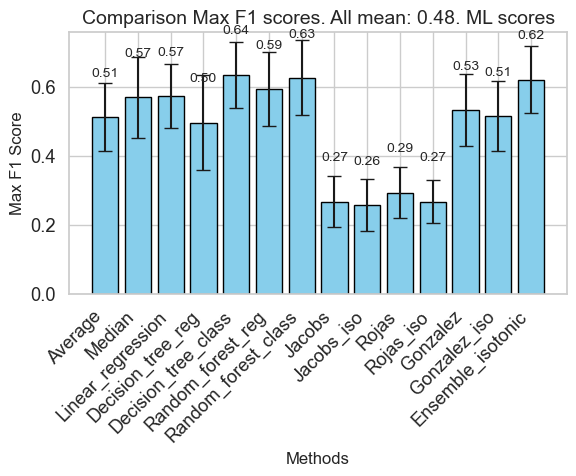

In [12]:
#Distribution f1 scores
sns.set(style='whitegrid', font_scale=1.2)

methods = list(data_perf.keys())
plt.figure(figsize=(6, 5))
bars = plt.bar(methods, avg_f1, yerr=std_f1, capsize=5, color='skyblue', edgecolor='black')

for bar, score in zip(bars, avg_f1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.11, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Comparison Max F1 scores. All mean: {:.2f}. ML scores'.format(aver_all), fontsize=14)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('Max F1 Score', fontsize=12)
plt.ylim(0, 0.76)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()
plt.close()

Average: 0.87
Median: 0.91
Linear_regression: 0.92
Decision_tree_reg: 0.90
Decision_tree_class: 0.86
Random_forest_reg: 0.92
Random_forest_class: 0.88
Jacobs: 0.66
Jacobs_iso: 0.69
Rojas: 0.83
Rojas_iso: 0.83
Gonzalez: 0.92
Gonzalez_iso: 0.91
Ensemble_isotonic: 0.92


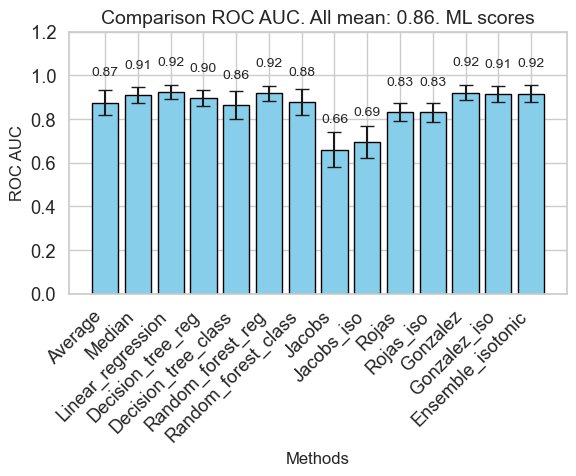

In [13]:
#Distribution roc auc values
for i in range(len(data_perf)):
    method = list(data_perf.keys())[i]
    print('{}: {:.2f}'.format(method, avg_roc_auc[i]))

sns.set(style='whitegrid', font_scale=1.2)

methods = list(data_perf.keys())
plt.figure(figsize=(6, 5))
bars = plt.bar(methods, avg_roc_auc, yerr=std_roc_auc, capsize=5, color='skyblue', edgecolor='black')

for bar, score in zip(bars, avg_roc_auc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.11, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Comparison ROC AUC. All mean: {:.2f}. ML scores'.format(np.mean(avg_roc_auc)), fontsize=14)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.ylim(0, 1.2)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()
plt.close()

Average: 1.39
Median: 1.48
Linear_regression: 1.50
Decision_tree_reg: 1.39
Decision_tree_class: 1.50
Random_forest_reg: 1.51
Random_forest_class: 1.50
Jacobs: 0.93
Jacobs_iso: 0.95
Rojas: 1.12
Rojas_iso: 1.10
Gonzalez: 1.45
Gonzalez_iso: 1.43
Ensemble_isotonic: 1.54
Average for all methods: 1.34


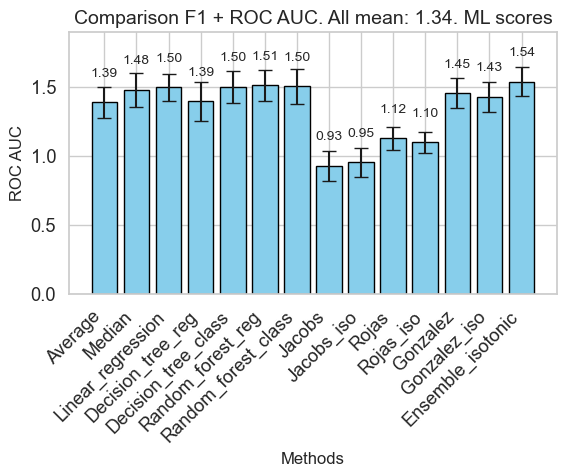

In [14]:
#Distribution f1 scores + roc auc values
new_list = np.array(avg_f1) + np.array(avg_roc_auc)
std_list = np.sqrt(np.array(std_f1)**2 + np.array(std_roc_auc)**2)

for i in range(len(data_perf)):
    method = list(data_perf.keys())[i]
    print('{}: {:.2f}'.format(method, new_list[i]))

aver_all = np.mean(new_list)
print('Average for all methods: {:.2f}'.format(np.mean(new_list)))



sns.set(style='whitegrid', font_scale=1.2)

methods = list(data_perf.keys())
plt.figure(figsize=(6, 5))
bars = plt.bar(methods, new_list, yerr = std_list, capsize=5, color='skyblue', edgecolor='black')

for bar, score in zip(bars, new_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.17, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Comparison F1 + ROC AUC. All mean: {:.2f}. ML scores'.format(np.mean(new_list)), fontsize=14)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.ylim(0, 1.9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()
plt.close()

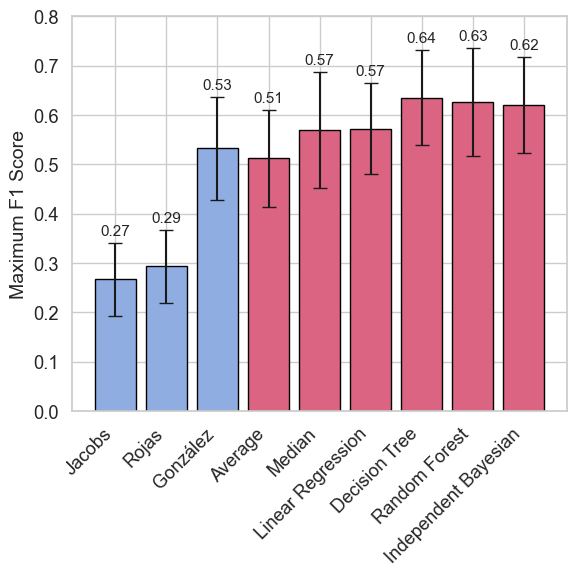

In [19]:
#Figure for paper
plt.rcParams["pdf.fonttype"] = 42  # Ensures text is stored as a TrueType font
plt.rcParams["font.family"] = "serif"
path_save_fig = 'Figures/'
name_file = 'Ensemble_f1scores.pdf'

methods = ['Jacobs', 'Rojas', 'Gonzalez', 'Average', 'Median', 'Linear_regression', 'Decision_tree_class',
           'Random_forest_class', 'Ensemble_isotonic'] #'Decision_tree_reg', 'Random_forest_reg'
titles = {'Jacobs': 'Jacobs', 'Rojas': 'Rojas', 'Gonzalez': 'González', 'Average': 'Average', 'Median': 'Median', 
          'Linear_regression': 'Linear Regression', 'Decision_tree_class': 'Decision Tree',
           'Random_forest_class': 'Random Forest', 'Ensemble_isotonic': 'Independent Bayesian'}

avg_f1, std_f1 = [], []
for method in methods:
    avg_f1.append(np.mean(data_perf[method]['max_f1']))
    std_f1.append(np.std(data_perf[method]['max_f1']))

aver_all = np.mean(avg_f1)

sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(6, 6))

# Define custom colors for the bars
highlight_methods = ['Jacobs', 'Rojas', 'Gonzalez'] #'#A9C1E9'
bar_colors = ['#90ADE2' if method in highlight_methods else '#DA6482' for method in methods]

# Create bar plot with individual colors
bars = plt.bar(list(titles.values()), avg_f1, yerr=std_f1, capsize=5, color=bar_colors, edgecolor='black')

for bar, score, err in zip(bars, avg_f1, std_f1):
    height = bar.get_height() + err  
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=11)

#plt.title('Comparison Ensemble Methods', fontsize=14)
#plt.xlabel('Ensemble Methods', fontsize=14)
plt.ylabel('Maximum F1 Score', fontsize=14)
plt.ylim(0, 0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.savefig(path_save_fig + name_file, format="pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [16]:
amdfkmadlkfmak

NameError: name 'amdfkmadlkfmak' is not defined

In [ ]:
#Loading data in intersection:

filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/'
data_inter = pd.read_csv(filepath + 'intersection.csv')
data_inter = data_inter.dropna()  # Remove rows with NaN values
data_inter = data_inter.replace([np.inf, -np.inf], np.nan).dropna()

#data_inter['ML_average'] = data_inter[['score_sims', 'K_SCORE', 'SINGLE']].mean(axis=1)
#data_inter['ML_median'] = data_inter[['score_sims', 'K_SCORE', 'SINGLE']].median(axis=1)

coadd_inter = data_inter[['COADD_OBJECT_ID']]
data_inter = data_inter[['score_sims', 'K_SCORE', 'SINGLE']]

In [ ]:
# For each method, add the new score from each new 'ensemble' method to inter_data

#average & median done
data_inter_complete = data_inter.copy()

#'ML_average', 'ML_median',
data_inter_complete['ML_average'] = data_inter[['score_sims', 'K_SCORE', 'SINGLE']].mean(axis=1)
data_inter_complete['ML_median'] = data_inter[['score_sims', 'K_SCORE', 'SINGLE']].median(axis=1)
data_inter_complete['linear_reg'] = model.predict(data_inter)/3
data_inter_complete['dec_tree_reg'] = dt_model.predict(data_inter.values)/3
data_inter_complete['dec_tree_class'] = dt_model_class.predict_proba(data_inter)[:,1]
data_inter_complete['random_for_reg'] = rf_model.predict(data_inter.values)/3
data_inter_complete['random_for_class'] = rf_model_class.predict_proba(data_inter)[:,1]  # assuming binary classification
data_inter_complete['jacobs'] = data_inter['score_sims']
data_inter_complete['jacobs_iso'] = jacobs_iso.predict(data_inter['score_sims'])/3
data_inter_complete['rojas'] = data_inter['K_SCORE']
data_inter_complete['rojas_iso'] = rojas_iso.predict(data_inter['K_SCORE'])/3
data_inter_complete['gonzalez'] = data_inter['SINGLE']
data_inter_complete['gonzalez_iso'] = gonzalez_iso.predict(data_inter['SINGLE'])/3
#ensemble
N_lens = sum(y_train['average'] > score_threshold)
N_Nlens = len(y_train) - N_lens
calib_jacob = jacobs_iso.predict(data_inter['score_sims'])/3
calib_rojas = rojas_iso.predict(data_inter['K_SCORE'])/3
calib_gonza = gonzalez_iso.predict(data_inter['SINGLE'])/3
prob_ens_num = calib_jacob*calib_rojas*calib_gonza/N_lens**2
prob_ens_denum = prob_ens_num + (1-calib_jacob)*(1-calib_rojas)*(1-calib_rojas)/N_Nlens**2
prob_ens = prob_ens_num/(prob_ens_denum)
data_inter_complete['ensemble'] = prob_ens

In [ ]:
#Adding values (new scores) from new methods using inter_data to the test data

new_data_test = pd.DataFrame()
new_data_test['COADD_OBJECT_ID'] = coadd_test['COADD_OBJECT_ID']
new_data_test['average'] = y_test['average']

data_inter_complete['COADD_OBJECT_ID'] = coadd_inter['COADD_OBJECT_ID']
new_data_test = new_data_test.merge(data_inter_complete, on='COADD_OBJECT_ID')
ensemble_methods = ['score_sims', 'K_SCORE', 'SINGLE', 'ML_average', 'ML_median', 'linear_reg', 'dec_tree_reg',
       'dec_tree_class', 'random_for_reg', 'random_for_class', 'jacobs','jacobs_iso', 'rojas', 'rojas_iso', 
        'gonzalez', 'gonzalez_iso', 'ensemble']

In [ ]:
# Distribution of scores that good candidates in test receive, in background all distribution for all in inter

to_skip = ['COADD_OBJECT_ID']
cols_to_plot = [col for col in data_inter_complete.columns if col not in to_skip]
n_cols = 4

for i in range(0, len(cols_to_plot), n_cols):
    group = cols_to_plot[i:i+n_cols]
    n_subplots = len(group)

    fig, axes = plt.subplots(1, n_subplots, figsize=(5 * n_subplots, 4))
    if n_subplots == 1:
        axes = [axes]

    for ax, col in zip(axes, group):
        # Combine data for consistent bins
        combined = pd.concat([
            data_inter_complete[col].dropna(),
            new_data_test[new_data_test['average'] > score_threshold][col].dropna()
        ])
        
        # Define bins with fixed width or count
        bins = np.histogram_bin_edges(combined, bins=20)  # or use np.linspace(0, 1, 21) for fixed range

        # Plot both histograms with same bins
        ax.hist(data_inter_complete[col].dropna(), bins=bins, color='skyblue', edgecolor='black', label='All')
        ax.hist(new_data_test[new_data_test['average'] > score_threshold][col].dropna(), 
                bins=bins, color='green', edgecolor='black', alpha=0.6, label='Candidates')

        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.set_ylim(0, 10**6)
        #ax.set_xlim(0, 1)
        ax.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# Saving data for plot: Num cand. vs Num. images to inspect

score_threshold = 1.75
N_lenses = len(new_data_test[new_data_test['average'] > score_threshold])
print(N_lenses, '\n')

N_points = 50
Num_images = {method: [] for method in ensemble_methods}
Num_lenses = {method: [] for method in ensemble_methods}
for i in range(len(ensemble_methods)):
    method = ensemble_methods[i]
    scores = np.linspace(min(new_data_test[method]), max(new_data_test[method]), N_points)
    for j in range(len(scores)):
        data_tmp = new_data_test[new_data_test['average'] > score_threshold]
        data_tmp = data_tmp[data_tmp[method] >= scores[j]]
        Num_lenses[method].append(len(data_tmp))
        data_tmp = data_inter_complete[data_inter_complete[method] >= scores[j]]
        Num_images[method].append(len(data_tmp))
        

In [ ]:
# Num lenses vs Num images to inspect


to_skip = ['COADD_OBJECT_ID']
cols_to_plot = [col for col in data_inter_complete.columns if col not in to_skip]
n_cols = 4

for i in range(0, len(cols_to_plot), n_cols):
    group = cols_to_plot[i:i+n_cols]
    n_subplots = len(group)

    fig, axes = plt.subplots(1, n_subplots, figsize=(5 * n_subplots, 4))
    if n_subplots == 1:
        axes = [axes]

    for ax, col in zip(axes, group):
        
        ax.plot(Num_images[col], Num_lenses[col], 'o')
        ax.set_title(col)
        ax.set_xlabel('Number Images to Inspect')
        ax.set_ylabel('Number Recovered Candidates')
        #ax.set_yscale('log')
        #ax.set_ylim(1, 10**6)
        #ax.set_xlim(-5, 3000)
        ax.set_ylim(0, N_lenses+1)
        ax.set_xlim(0.5, 10**6)
        ax.set_xscale('log')

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
# Printing numbers for paper

print(Num_images.keys())

In [ ]:
# Printing numbers for paper

methods = ['score_sims', 'K_SCORE', 'SINGLE', 'ML_average', 'ML_median', 'linear_reg', 
           'dec_tree_class', 'random_for_class', 'ensemble']

for i in range(len(methods)):
    col = methods[i]
    new_data = pd.DataFrame(np.column_stack((Num_images[col], Num_lenses[col])), columns=['N_images', 'N_cand'])
    
    data_tmp = new_data[new_data['N_cand'] == 10]
    if data_tmp.empty:
        # Find unique N_cand values and compute their absolute difference from 10
        unique_vals = new_data['N_cand'].unique()
        closest_diff = abs(unique_vals - 10).min()
        closest_vals = unique_vals[abs(unique_vals - 10) == closest_diff]
        data_tmp = new_data[new_data['N_cand'].isin(closest_vals)]
    
    #print(data_tmp)
    print(col, data_tmp['N_images'].min(), data_tmp['N_cand'].iloc[0])

## Replying to Tom and Natalie

In [ ]:
data_inter_complete.columns
ensemble_methods = ['ML_average', 'ML_median', 'linear_reg', 'dec_tree_class', 'random_for_class', 'ensemble']
ml_pairs = [['score_sims', 'K_SCORE'], ['score_sims', 'SINGLE'], ['K_SCORE', 'SINGLE']]
title_plot = {'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}

for i in range(len(ensemble_methods)):
    method = ensemble_methods[i]
    print(method)
    
    cte = 15/max(data_inter_complete[method])
    size = (cte*data_inter_complete[method] + [0.4]*len(data_inter_complete))**2.5 #**2
    print(max(size))
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.4})
    for j in range(3):        
        ml1, ml2 = ml_pairs[j]
        
        axs[j].set_xlabel(title_plot[ml1], fontsize=14)
        axs[j].set_ylabel(title_plot[ml2], fontsize=14)

        #im = axs[i].hist2d(data_tmp[ml1], data_tmp[ml2], bins=5, cmap=custom_cmap, vmin=1, vmax=max_count)[-1]

        axs[j].set_xticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        axs[j].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]

        axs[j].scatter(data_inter_complete[ml1], data_inter_complete[ml2], alpha=0.4, s=size.values, 
            edgecolors='#1b67d2', facecolors='none', linewidth=0.1)
        #plt.scatter(cand_sled['score_sims'], cand_sled['K_SCORE'], alpha=1, s=size.values, 
        #    edgecolors='#00FFFF', facecolors='none', linewidth=0.3)
    
        #plt.suptitle(titles_text[j], fontsize=16, y=0.98)
    plt.show()
    

In [ ]:
data_inter_complete = data_inter_complete.merge(data_zoo[['COADD_OBJECT_ID', 'average']], on='COADD_OBJECT_ID', how='left')

data_inter_complete['average'] = data_inter_complete['average'].fillna(-1)

In [ ]:
#Improving the previous plots 

color_list = ['#cc224d', '#2cf531', '#2d8dff']
ensemble_methods = ['ML_average', 'ML_median', 'linear_reg', 'dec_tree_class', 'random_for_class', 'ensemble']
ml_pairs = [['score_sims', 'K_SCORE'], ['score_sims', 'SINGLE'], ['K_SCORE', 'SINGLE']]
title_plot = {'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}

for i in range(len(ensemble_methods)):
    method = ensemble_methods[i]
    print(method)
    data_tmp = data_inter_complete.sort_values(by=method, ascending=False)
    data_tmp = data_tmp.head(1000)
    
    cte = 10/max(data_tmp[method])
    size = (cte*data_tmp[method] + [0.4]*len(data_tmp))**2.5 #**2
    print(max(size))
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.4})
    for j in range(3):        
        ml1, ml2 = ml_pairs[j]
        
        axs[j].set_xlabel(title_plot[ml1], fontsize=14)
        axs[j].set_ylabel(title_plot[ml2], fontsize=14)

        axs[j].set_xticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        axs[j].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]

        axs[j].scatter(data_tmp[ml1], data_tmp[ml2], alpha=0.6, s=size.values, 
            edgecolors='#1b67d2', facecolors='none', linewidth=0.2)
        #plt.suptitle(titles_text[j], fontsize=16, y=0.98)
    plt.show()

In [ ]:
color_list      = ['#1b67d2', '#2cf531', '#cc224d']         # 0, 1, 2
ensemble_methods = ['ML_average', 'ML_median', 'linear_reg',
                    'dec_tree_class', 'random_for_class', 'ensemble']
ml_pairs         = [['score_sims', 'K_SCORE'],
                    ['score_sims', 'SINGLE'],
                    ['K_SCORE',   'SINGLE']]
title_plot       = {'score_sims': 'Jacobs',
                    'K_SCORE'  : 'Rojas',
                    'SINGLE'   : 'González'}

# --- helper to convert “average” to a colour -------------------------------
def average_to_color(series, colours=color_list):
    """
    Map each value in *series* to a colour in *colours*
       <=1.25  -> colours[0]
       1.25-2  -> colours[1]
       >2      -> colours[2]
    Returns a numpy array of hex strings, ready to pass to scatter().
    """
    bins   = [-np.inf, 1.25, 2.0, np.inf]
    labels = [0, 1, 2]                      # index into colour_list
    idx    = pd.cut(series, bins=bins, labels=labels).astype(int)
    return np.array([colours[i] for i in idx])

# --------------------------------------------------------------------------
for method in ensemble_methods:
    print(method)
    data_tmp = (
        data_inter_complete
        .sort_values(by=method, ascending=False)
        .head(300)
        .copy()
    )
    
    data_tmp = data_tmp.sort_values(by='average')

    # symbol sizes (your original recipe)
    cte  = 10 / data_tmp[method].max()
    size = (cte * data_tmp[method] + 0.4)**2.5

    # colours for every point
    point_colours = average_to_color(data_tmp['average'])

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4),
                            gridspec_kw={'wspace': 0.4})

    for ax, (ml1, ml2) in zip(axs, ml_pairs):

        ax.set_xlabel(title_plot[ml1], fontsize=14)
        ax.set_ylabel(title_plot[ml2], fontsize=14)
        ax.set_ylim(-0.03, 1.03)
        ax.set_xlim(-0.03, 1.03)
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.set_yticks(np.linspace(0, 1, 6))

        ax.scatter(
            data_tmp[ml1],
            data_tmp[ml2],
            s=30,
            c = point_colours,
            #facecolors='none',              # empty circles
            #edgecolors=point_colours,
            alpha=0.4,
            linewidth=0.8
        )

    plt.show()
    

In [ ]:
print(len(data_tmp[(data_tmp['average'] > 1.5) & (data_tmp['average'] <= 2)]))

In [ ]:
print(len(data_inter_complete[data_inter_complete['average'] <= 1.5]))
print(len(data_inter_complete[(data_inter_complete['average'] > 1.5) & (data_inter_complete['average'] <= 2)]))
print(len(data_inter_complete[data_inter_complete['average'] > 2]))

In [ ]:
data_inter_complete

In [ ]:
#Studying correlation between each ensemble score and each of the individual ML models:

from scipy.stats import spearmanr

# Calculate Spearman rank correlation
correlation, p_value = spearmanr(data_inter_complete['score_sims'], data_inter_complete['ML_average'])

print(f"Spearman correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3g}")

In [ ]:
methods

In [ ]:
ml_models = ['score_sims', 'K_SCORE', 'SINGLE']

for i in range(len(methods)):
    method = methods[i]
    if method in ml_models:
        continue
    print(method)
    for j in range(len(ml_models)):
        correlation, p_value = spearmanr(data_inter_complete[ml_models[j]], data_inter_complete[method])
        print(ml_models[j], correlation, p_value)
    print(' ')

In [ ]:
print(len(data_tmp))

ml_models = ['score_sims', 'K_SCORE', 'SINGLE']

for i in range(len(methods)):
    method = methods[i]
    if method in ml_models:
        continue
    print(method)
    for j in range(len(ml_models)):
        correlation, p_value = spearmanr(data_tmp[ml_models[j]], data_tmp[method])
        print(ml_models[j], correlation, p_value)
    print(' ')